In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [4]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

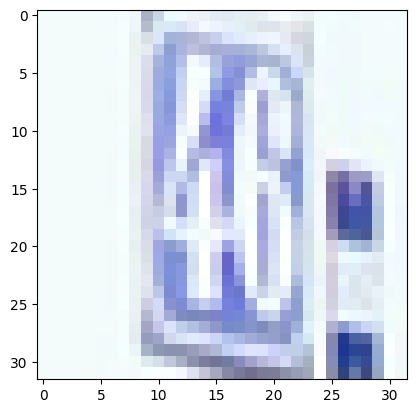

In [5]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

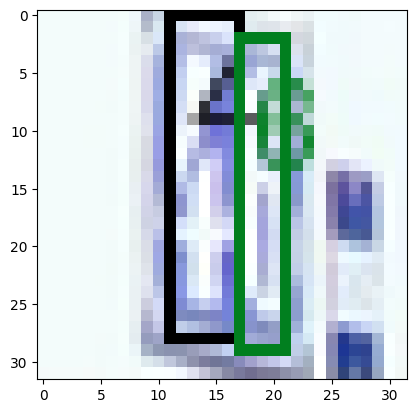

In [6]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [7]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [8]:
len(dataloader)

1

In [9]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]]), tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4426, 0.5000, 0.1967, 0.7419],
        [0.5902, 0.5323, 0.1639, 0.7419]])


NameError: name 'anchors' is not defined

In [ ]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [10]:
import json

In [13]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=250,
    lr=3e-3,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 250/250 [00:38<00:00,  6.43it/s, class_loss=0.0028, conf_loss=0.00403, coord_loss=0.000313, loss=0.00545] 


[0.993661642074585,
 0.8788566589355469,
 0.8026113510131836,
 0.7528820037841797,
 0.7145462036132812,
 0.6848787069320679,
 0.6556229591369629,
 0.6252787113189697,
 0.5981928110122681,
 0.5726339817047119,
 0.5483272075653076,
 0.5253174304962158,
 0.5037145614624023,
 0.48346564173698425,
 0.4648815095424652,
 0.4474050998687744,
 0.43038874864578247,
 0.41394752264022827,
 0.3984043002128601,
 0.38378778100013733,
 0.36976364254951477,
 0.35622352361679077,
 0.3433501124382019,
 0.33118149638175964,
 0.3195803165435791,
 0.308409184217453,
 0.29771316051483154,
 0.2875540852546692,
 0.27791619300842285,
 0.26867467164993286,
 0.25973623991012573,
 0.25082722306251526,
 0.2421724945306778,
 0.23381221294403076,
 0.22576232254505157,
 0.21803951263427734,
 0.21066728234291077,
 0.20364098250865936,
 0.19693787395954132,
 0.1905622035264969,
 0.1844962239265442,
 0.17870739102363586,
 0.173153817653656,
 0.16782888770103455,
 0.16272833943367004,
 0.15783916413784027,
 0.153137698769

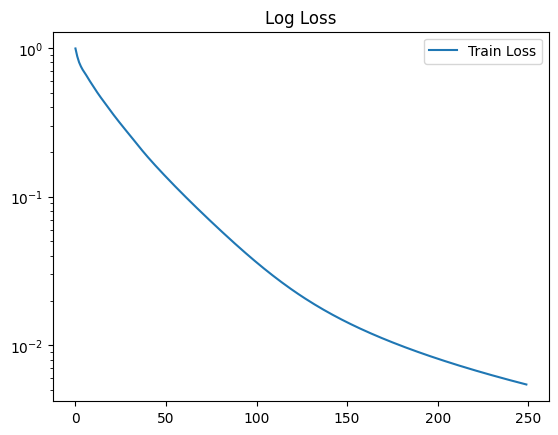

In [14]:
trainer.train()

In [15]:
pred = model(batch["images"])
pred.shape

torch.Size([2, 4, 4, 30])

In [16]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([-0.0695, -0.2035, -0.5383,  1.0474, -5.5229,  0.2832,  0.3393,  0.0082,
          0.3126, -0.3216,  0.1543,  0.0756,  0.3261,  0.1271, -0.0644,  0.1992,
          1.4399, -0.2893,  0.3545, -5.7222, -0.8096, -2.9280, -0.4970, -0.3850,
          1.9207, -0.6965, -1.0394,  0.4440,  0.2888, -0.9119],
        grad_fn=<SliceBackward0>),
 tensor([ 0.3997, -0.4890, -0.3833,  0.0316, -5.3026,  0.5631,  0.3458,  0.4559,
          0.2895, -0.7254, -0.3527,  1.0164, -0.3349,  0.5644, -0.6057,  0.9079,
         -0.0299, -0.3224,  0.4026, -5.5022, -2.0992, -1.6296, -1.5879, -0.4433,
          2.0593, -1.3417, -1.4902, -1.6487, -0.9312, -2.1751],
        grad_fn=<SliceBackward0>))

In [17]:
i = 1

In [18]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4426, 0.5000, 0.1970, 0.7412],
          [0.5901, 0.5323, 0.1641, 0.7419]]),
  'confidence': tensor([0.9958, 0.9950]),
  'labels': tensor([7, 1]),
  'scores': tensor([0.9999, 0.9998])},
 {'bboxes': tensor([[0.6075, 0.5000, 0.1493, 0.8703],
          [0.4533, 0.4515, 0.1962, 0.8695]]),
  'confidence': tensor([0.9983, 0.9940]),
  'labels': tensor([6, 4]),
  'scores': tensor([0.9998, 0.9999])}]

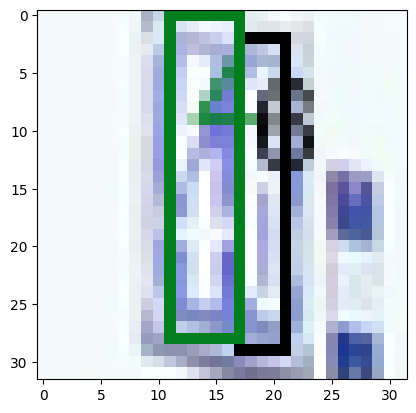

In [19]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

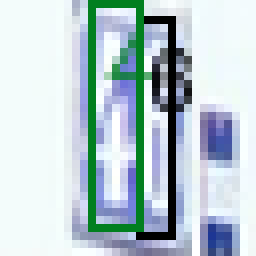

In [20]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [83]:
calculate_mAP(
    model,
    trainer.train_loader,
)

100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


{'map': 1.0,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}